In [1]:
import os
import numpy as np
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()
client = OpenAI()
print("OpenAI client initialized successfully")


OpenAI client initialized successfully


# Document Parsing & Data Quality for RAG

## Table of Contents
1. [Why Data Quality Matters in RAG](#1-why-data-quality-matters-in-rag)
2. [The Problem with Naive Text Extraction](#2-the-problem-with-naive-text-extraction)
3. [Document Parsing Approaches](#3-document-parsing-approaches)
4. [Document Structure: The Hierarchy](#4-document-structure-the-hierarchy)
5. [Handling Tables, Charts, and Images](#5-handling-tables-charts-and-images)
6. [Embeddings: Text to Vectors](#6-embeddings-text-to-vectors)
7. [Vector Search & Similarity](#7-vector-search--similarity)
8. [Vector Databases](#8-vector-databases)
9. [Chunking Strategies](#9-chunking-strategies)
10. [The Complete Indexing Pipeline](#10-the-complete-indexing-pipeline)
11. [Improving RAG Through Better Data Quality](#11-improving-rag-through-better-data-quality)

---



# 1. Why Data Quality Matters in RAG

## The Fundamental Principle
> **"Garbage in, garbage out"** — The upper limit of a RAG system's performance is determined by the quality of your data.

RAG systems can only retrieve and generate **answers based on what's been indexed**. If the indexed data is:
- **Incorrectly parsed** → Wrong information gets retrieved
- **Poorly chunked** → Context is incomplete or irrelevant
- **Missing semantic meaning** → Embeddings don't capture the true content

## The RAG Pipeline Overview
```text
Data → Parsing → Chunking → Indexing → Retrieval → Generation
```

Each stage affects the final answer quality. Poor decisions early in the pipeline compound downstream.

---



# 2. The Problem with Naive Text Extraction

## What Happens with Simple Text Extraction

When you use basic tools like `pdftotext` or simple HTML parsers, several problems occur:

### 2.1 Broken Structure
| Problem | Example |
|---------|---------|
| Multi-column PDFs flattened | Text from Column A and Column B get interleaved |
| Tables lose structure | Numbers separated from their headers |
| Lists lose formatting | Bullet points become unstructured text |

### 2.2 Noise in the Signal
- **Headers and footers** get mixed into content
- **Page numbers** appear in the middle of paragraphs
- **Watermarks** like "Confidential – 2024 Q3" become part of searchable text

### 2.3 Lost Multimodal Information
- **Images** are dropped or become useless alt-text like "Figure 3"
- **Charts** lose all their data
- **Formulas** become unreadable character sequences

## Real-World Example: Earnings Statement

**Original Document:** A paystub with structured earnings, deductions, and tax information in neat columns.

**Naive OCR Output:**
```text
CO. FILE DEPT. CLOCK NUMBER ABC 126543 123456 12345 00000000
1 Earnings Statement ANY COMPANY CORP. Period ending:
7/18/2008 475 ANY AVENUE Pay date: 7/25/2008
ANYTOWN USA 10101 Social Security Number: 987-65-4321
this period year to date Other Benefits and Regular 10.00
32.00 320.00 16,640.00 Information this period total to date
```

The structure is completely lost. A query like "What was the federal income tax?" would struggle to find the answer.

### Why This Matters for RAG
- **Embeddings** computed on noisy, broken text become unreliable
- **Similarity search** fails because the semantic meaning is corrupted
- Even if the right page is retrieved, the **chunk itself** may not contain clean information

---



# 3. Document Parsing Approaches
A major challenge in building AI applications is getting data out of documents and into a format that LLMs can use. Documents contain a mix of elements: text, tables, images and figures, footers and references. Some documents can be thousands of pages long.

There are several Parsing Approaches.

## 3.1 Traditional OCR (Optical Character Recognition)

**Tools:** AWS Textract, Tesseract, Google Vision OCR

**Limitations:**
- No understanding of semantic meaning
- Doesn't consider document layout
- Accuracy issues with complex fonts or low-quality scans

## 3.2 Large Vision Models (LVMs)

**Tools:** GPT-4 Vision, Claude with vision, Gemini

**Advantages:**
- Understands both text AND layout
- Can interpret the meaning of tables and charts
- Generates human-readable descriptions

## 3.3 Hybrid Approaches (Recommended)

Combining OCR with LVMs yields the best results:

```text
    Step 1: Low-level extraction
    ├── Use PDF parser to get text fragments + bounding boxes
    ├── Extract raw text for each page
    └── Identify image regions

    Step 2: Page snapshot for LLM
    ├── Render each page as an image
    ├── Send image + raw text + layout info to vision LLM
    └── Example: GPT-4.1-mini with vision

    Step 3: LLM outputs structured blocks
    ├── Returns JSON list of blocks with:
    │   ├── type: (title, heading, paragraph, table, figure, etc.)
    │   ├── bbox: (approximate location)
    │   └── text: or short description
    └── Preserves semantic structure

    Step 4: Post-processing & clean-up
    ├── Merge small spans into paragraphs
    ├── Drop repeated headers/footers
    └── Normalize lists and code

    Step 5: Store as Document → Page → Block
    └── These labeled blocks become source of truth for chunking
```

---



# 4. Document Structure: The Hierarchy

## The Four-Level Hierarchy

```text
Document
├── Page 1
│   ├── Block 1 (Title)
│   ├── Block 2 (Paragraph)
│   ├── Block 3 (Table)
│   └── Block 4 (Figure)
├── Page 2
│   ├── Block 5 (Section Header)
│   ├── Block 6 (Paragraph)
│   └── ...
└── ...

Blocks → Combined into → Chunks (for embedding)
```

## Definitions

| Level | Definition | Example |
|-------|------------|---------|
| **Document** | Entire file | 80-page PDF, full web article |
| **Page** | Physical page (PDF) or logical section (web) | Page 5 of report |
| **Block** | Layout unit with semantic type | A paragraph, a table, a heading |
| **Chunk** | Text unit prepared for embedding & retrieval | 300-600 tokens of related content |



## Pages Segmentation (splitting)
Goal: for long documents, sometimes we only care about certain part of the document

Inputs Type 1:
- Chapter 1, Appendix 
Outputs Type 1: 
- {“Chapter 1ˮ: [10, 11, 12, ..., 20], “Appendixˮ: [99, 100, 101]}

Inputs Type 2
- Separate by chapters
Outputs Type 2
- [[10, 11, 12, ..., 20], [20, ..., 29], ..., [99, 100, 101]]

## Block Types



In [10]:
from enum import Enum
from pydantic import BaseModel, Field
from typing import List, Dict, Any


class BlockType(str, Enum):
    """
    Classification of document block types.
    Each block type has different embedding and retrieval characteristics.
    """
    TITLE = "Title"
    SECTION_HEADER = "Section Header"
    PARAGRAPH = "Paragraph"
    LIST_ITEM = "List Item"
    TABLE = "Table"
    FIGURE = "Figure"
    IMAGE = "Image"
    HEADER = "Header"
    FOOTER = "Footer"


class DocumentBlock(BaseModel):
    """
    A block of content extracted from a document.
    
    Key fields:
    - content: Raw content for display
    - semantic_content: AI-generated description for embedding
    """
    type: BlockType
    page_num: int
    content: str
    semantic_content: str = Field(
        description="AI-generated semantic description optimized for embedding"
    )


class DocumentChunk(BaseModel):
    """
    A chunk composed of one or more blocks.
    This is what gets embedded and indexed for retrieval.
    """
    content: str
    embed: str = Field(description="Text used for embedding")
    blocks: List[DocumentBlock]
    metadata: Dict[str, Any]


print("Document parsing models defined")
print(f"\nAvailable BlockTypes:")
for bt in BlockType:
    print(f"  - {bt.value}")


Document parsing models defined

Available BlockTypes:
  - Title
  - Section Header
  - Paragraph
  - List Item
  - Table
  - Figure
  - Image
  - Header
  - Footer


In [11]:
"""
Simulate document parsing: a parsed PDF page with multiple blocks.
"""

sample_blocks = [
    DocumentBlock(
        type=BlockType.TITLE,
        page_num=1,
        content="Q3 2024 Financial Report",
        semantic_content="Title of the document: Q3 2024 Financial Report. This is a quarterly financial statement."
    ),
    DocumentBlock(
        type=BlockType.SECTION_HEADER,
        page_num=1,
        content="Revenue Summary",
        semantic_content="Section header for revenue summary section containing financial metrics."
    ),
    DocumentBlock(
        type=BlockType.PARAGRAPH,
        page_num=1,
        content="Total revenue for Q3 2024 was $42.5 million, representing a 35% increase year-over-year.",
        semantic_content="Q3 2024 revenue was $42.5 million, which is a 35% year-over-year growth compared to Q3 2023."
    ),
    DocumentBlock(
        type=BlockType.TABLE,
        page_num=1,
        content="<table><tr><th>Quarter</th><th>Revenue</th></tr><tr><td>Q3 2024</td><td>$42.5M</td></tr><tr><td>Q3 2023</td><td>$31.5M</td></tr></table>",
        semantic_content="Revenue comparison table showing Q3 2024 revenue of $42.5M versus Q3 2023 revenue of $31.5M, indicating $11M increase."
    ),
]

print("Parsed Document Blocks:")
print("=" * 60)

for i, block in enumerate(sample_blocks):
    print(f"\n[Block {i+1}] Type: {block.type.value}, Page: {block.page_num}")
    print(f"  Content: {block.content[:80]}..." if len(block.content) > 80 else f"  Content: {block.content}")
    print(f"  Semantic: {block.semantic_content[:80]}..." if len(block.semantic_content) > 80 else f"  Semantic: {block.semantic_content}")


Parsed Document Blocks:

[Block 1] Type: Title, Page: 1
  Content: Q3 2024 Financial Report
  Semantic: Title of the document: Q3 2024 Financial Report. This is a quarterly financial s...

[Block 2] Type: Section Header, Page: 1
  Content: Revenue Summary
  Semantic: Section header for revenue summary section containing financial metrics.

[Block 3] Type: Paragraph, Page: 1
  Content: Total revenue for Q3 2024 was $42.5 million, representing a 35% increase year-ov...
  Semantic: Q3 2024 revenue was $42.5 million, which is a 35% year-over-year growth compared...

[Block 4] Type: Table, Page: 1
  Content: <table><tr><th>Quarter</th><th>Revenue</th></tr><tr><td>Q3 2024</td><td>$42.5M</...
  Semantic: Revenue comparison table showing Q3 2024 revenue of $42.5M versus Q3 2023 revenu...


## Metadata at Each Level

**Document Level:**
- `document_id`, `title`, `source_type` (pdf, html, url)
- `source_url`, `uploaded_by`, `created_at`
- Access control: `tenant_id`, allowed users/groups

**Page Level:**
- `page_number`, `width`, `height`
- `image_path` (for previews)
- Pointer to all blocks on that page

**Block Level:**
- `block_id`, `block_type`
- `text` or `structured_data` (for tables)
- `bbox` (bounding box coordinates)
- `heading_path` (e.g., "Ch 3 > 3.2 RAG Limitations")
- `semantic_content`: LLM-generated summary for embeddings

**Chunk Level:**
- `chunk_id`, `document_id`, `page_number`
- `source_block_ids` (which blocks make up this chunk)
- `text` (final text for embedding)
- Optional: `title`, `section`

---



# 5. Handling Tables, Charts, and Images

## The Core Problem

Raw structured data embeds poorly because embedding models cannot preserve structural relationships.

**Example - Raw Table HTML:**
```html
<table><tr><th>FY</th><th>Rev($M)</th><th>YoY%</th></tr>
<tr><td>24Q3</td><td>42.5</td><td>+35</td></tr>
<tr><td>23Q3</td><td>31.5</td><td>+22</td></tr></table>
```

**Query:** "Is the company's revenue growth accelerating or slowing down?"

| Content Type | Cosine Similarity |
|--------------|-------------------|
| Raw HTML table | 0.4312 |
| Semantic description | 0.5903 |
| **Improvement** | **+36.9%** |



## Solution: Semantic Content

For each table/chart/image, generate a `semantic_content` field:

**Raw Chart Data:**
```text
Figure 3. [x: Jan, Feb, Mar...Sep] [y: 2.1, 2.3, 2.8...5.2]
```

**Semantic Content:**
```text
Line chart showing monthly revenue growth from January to September 2024. 
Revenue increased steadily from $2.1M in January to $5.2M in September, 
with the strongest growth in the second half of the year.
```



## Handling Different Content Types

### Tables
1. Extract table structure (HTML, Markdown, or JSON)
2. Handle merged cells with rowspan/colspan
3. Generate **semantic summary describing**:
   - What the table compares
   - Key insights from the data
   - Trends or notable values

**Output Formats:**
- **HTML**: Complex structures with merged cells
- **Markdown**: Human-readable format
- **JSON**: Machine-readable for processing
- **CSV**: Sheet-ready format

### Images
**Digital PDFs:**
- Can access underlying images directly
- Challenge: Filter out decorative images
- Bounding boxes easily obtainable

**Scanned PDFs:**
- Use **LVM** on full page to get descriptions
- Need advanced models for bounding boxes
- Can clip partial images for focused analysis

### Charts
- Generate **summary/description**
- Extract structured data representation
- **Similar approach to images**
- Special case: Some charts are composed of multiple images

---



# 6. Embeddings: Text to Vectors

## What is an Embedding?

An embedding maps text to a vector in N-dimensional space, where **distance indicates semantic similarity**.

```text
"I love dogs"     → [0.037, -0.041, -0.026, 0.018, ...]
"I love cats"     → [0.005, -0.044, -0.050, 0.038, ...]
"The weather..."  → [0.015, -0.017, -0.018, -0.015, ...]
```

Semantically similar texts end up **close together** in vector space.

## Key Attributes of Embedding Models

When selecting an embedding model, consider the following attributes based on 
your specific needs:
- **Number of Parameters**: **the size and resource requirements of the model**. 
  - How large of the resources required to run the model.
  - Larger models: 
    - Pros: Offer higher performance
    - Cons: Require more significant computational resources for inference.
- **Number of Dimensions**: The **length of the generated vector**.    
  - Larger can capture more **varied and detailed information**. 
  - A model with more dimensions (e.g., 1536 vs. 384)
    - Pros: Capture more semantic detail. 
    - Cons: Increases storage and computational costs
- **Max Tokens**:
  - The **maximum length of text** that can be converted into **a single vector**. 
  - Texts exceeding this limit must be processed using a chunking strategy.


| Attribute | Description | Trade-off |
|-----------|-------------|-----------|
| **Dimensions** | Length of output vector (384, 768, 1536, 3072) | Higher = more detail but more storage/compute |
| **Max Tokens** | Maximum text length per embedding | Texts exceeding must be chunked |
| **Parameters** | Model size | Larger = better quality but slower inference |



## Dimension Trade-offs

Intuitively, you can think of each dimension as one **latent feature channel** the model can use to encode semantic information

**Higher Dimensions (e.g., 3072):**
- ✅ Capture more semantic detail
- ✅ More "directions" to separate concepts
- ❌ Storage: `#vectors × dimension × 4 bytes` (float32)
- ❌ Compute: More operations per similarity calculation
- ❌ ANN indexes become less efficient

**Practical Recommendations:**
- Small/mid-scale apps: **384–768 dims**
- Large-scale, high-quality retrieval: **768–1536 dims**


## Choosing an Embedding Model

1. **Check MTEB leaderboard:** https://huggingface.co/spaces/mteb/leaderboard
   - Provide detailed scores across various tasks and domains
   - Per task category scores
   - Per task scores (domain specific)
   - Zero-shot %: how much of the testing data is not “seenˮ (used for training)
2. **Consider your constraints:**
   - Budget (API costs vs self-hosted)
   - Latency requirements
   - Domain specificity (general vs specialized)
3. **Rule of thumb:** Top proprietary models usually work well enough

OpenAI Embedding Models:  

| Model | Dimensions | Storage/Vector | Best For |
|-------|------------|----------------|----------|
| `text-embedding-3-small` | 1536 | 6,144 bytes | Fast, cheap, good quality |
| `text-embedding-3-large` | 3072 | 12,288 bytes | Highest quality |



## How Embedding Models are Trained

1. **Architecture:** Most are Transformer encoders (BERT-style)
2. **Process:** Input text → tokenization → contextual embeddings via multi-layer self-attention
3. **Pooling:** [CLS] token or mean pooling → **one fixed-length vector** for the whole text
4. **Training:** with **Contrastive learning** objective
   - Show model **positive pairs**: (query, relevant passage)
   - Treat other passages in the batch as **negatives**
   - Optimize a loss (e.g., InfoNCE) so that the similarity of positive pairs is higher than that of negatives

Over time, this shapes a **semantic space** where:
- Semantically similar texts end up **close** together,
- Unrelated texts are pushed **farther apart**


In [2]:
def get_embedding(text: str, model: str = "text-embedding-3-small"):
    """
    Generate embedding vector for given text using OpenAI API.
    
    Args:
        text: Input text to embed
        model: OpenAI embedding model name
    
    Returns:
        List of floats representing the embedding vector
    """
    response = client.embeddings.create(input=text, model=model)
    return response.data[0].embedding


sample_texts = [
    "I love dogs",
    "I love cats",
    "The weather is nice today"
]

embeddings = []
for text in sample_texts:
    emb = get_embedding(text)
    embeddings.append(emb)
    print(f"Text: '{text}'")
    print(f"  Dimensions: {len(emb)}")
    print(f"  First 5 values: {emb[:5]}")
    print()


Text: 'I love dogs'
  Dimensions: 1536
  First 5 values: [0.03723973408341408, -0.04162217304110527, -0.02655891142785549, 0.018223464488983154, 0.013609790243208408]

Text: 'I love cats'
  Dimensions: 1536
  First 5 values: [0.005527676548808813, -0.044771600514650345, -0.05075490102171898, 0.03837565705180168, -0.005573525559157133]

Text: 'The weather is nice today'
  Dimensions: 1536
  First 5 values: [0.015535500831902027, -0.017275476828217506, -0.018009882420301437, -0.015411216765642166, 0.03073204681277275]



## Model Types

- **Encoder-only models (BERT-style)**:
  - Pure encoders that take a sentence/paragraph and output a vector.
  - Common in **sentence-transformers** style models for retrieval / STS / clustering.
- **LLM-based embeddings (decoder-only)**:    
  - Reuse the last-layer hidden states of a GPT-like model and pool them into a vector.
  - Often **fine-tuned** with a contrastive loss specifically for retrieval.

**Bi-encoder / dual-encoder vs cross-encoder**
- **Bi/dual-encoder**: 
  - encode query and document separately, 
  - compare with cosine/dot product
  - fast, supports large-scale retrieval.
- **Cross-encoder**: 
  - feed query + document together and 
  - output a single relevance score
  - slow but very accurate, great for reranking top-K results.


| Type | Description | Use Case |
|------|-------------|----------|
| **Encoder-only (BERT-style)** | Pure encoders, output single vector | Retrieval, STS, clustering |
| **LLM-based (decoder-only)** | Reuse last-layer hidden states, pool to vector | Often fine-tuned for retrieval |
| **Bi-encoder** | Encode query & doc separately, compare with cosine | Fast, large-scale retrieval |
| **Cross-encoder** | Feed query+doc together, output relevance score | Slow but accurate, great for reranking |


Different embedding models mainly differ in:  
- Training data (general vs domain-specific, multilingual vs English-only),
- Training objective (retrieval, STS, classification, etc.),
- Architecture (encoder-only vs LLM-based),
- Vector dimension and max token length.


In [3]:
"""
Compare different OpenAI embedding models.
- text-embedding-3-small: 1536 dimensions, fast and cheap
- text-embedding-3-large: 3072 dimensions, higher quality
"""

test_text = "Machine learning is a subset of artificial intelligence."

models = [
    ("text-embedding-3-small", 1536),
    ("text-embedding-3-large", 3072),
]

print("Embedding Model Comparison:")
print("=" * 50)

for model_name, expected_dims in models:
    emb = get_embedding(test_text, model=model_name)
    print(f"\nModel: {model_name}")
    print(f"  Dimensions: {len(emb)} (expected: {expected_dims})")
    print(f"  Storage per vector: {len(emb) * 4} bytes (float32)")


Embedding Model Comparison:

Model: text-embedding-3-small
  Dimensions: 1536 (expected: 1536)
  Storage per vector: 6144 bytes (float32)

Model: text-embedding-3-large
  Dimensions: 3072 (expected: 3072)
  Storage per vector: 12288 bytes (float32)


## Common Task Types (for Text Embeddings)
Embedding models are versatile and can be applied to a variety of tasks including:

- **Bitext Mining**      
  - Find sentence pairs from **two languages** with the same meaning
  - Inputs:
    - I love traveling to new places.
    - Jʼadore voyager vers de nouveaux endroits.
  - Outputs: Match

- **Retrieval**      
  - Finding the **most similar texts to a given query** from a large corpus.

- **Clustering**      
  - **Grouping texts** based on their **similarity** without predefined categories.

- **Instruction Retrieval**
  - Get most relevant instructions form a corpus given a user query     

- **Classification (single / multi label)**
  - Assigning texts to **predefined categories**.
- **Pair Classification**
  - whether two texts are **semantically related**
- **Reranking**
  - **Improving the order** of search results based on **semantic relevance**.
- **Semantic Textual Similarity(STS)** 
  - Quantifying the similarity between two texts with a **numerical score**.

## Image-Text Embeddings
Multimodal embeddings project **different data types**, such as images and text, into a **shared latent space**. This enables cross-modal applications, such as using natural language queries to search a collection of images.

Benchmark tasks types:   
- Image Classification
- Image Clustering
- Document Understanding
- Compositionality
  - Test the modelʼs ability to generalize to novel combinations of known concepts
- Zero-shot Classification
  - Classify new, unseen categories using only text labels, without any fine-tuning
- Vision Centric QA

---

# 7. Vector Search & Similarity
- Vector search is the mechanism used **to find similarities between embedding vectors**. 
- Unlike traditional keyword search, which often relies on exact or fuzzy text matches, vector search captures **semantic meaning**. 
  - For example, a keyword search might miss the connection between "Bill" and "William," whereas a vector search would recognize their semantic relationship.
- The most common method for determining similarity is **Cosine Similarity**, which measures the **cosine of the angle between two vectors** in the embedding space. 
  - A **smaller angle** signifies a **higher cosine similarity** and thus a **closer semantic** relationship.
- Vector search retrieves information by finding the nearest neighbors to a query vector within an embedding space. 
- It operates on conceptual meaning, making it more robust than traditional keyword search, which relies on lexical matches and fails on synonyms or paraphrasing.

## Cosine Similarity

The standard metric for measuring similarity between embeddings.  

It calculates the **cosine of the angle (θ)** between two vectors, focusing on their direction rather than their magnitude. This is ideal for text analysis, where **topic (direction)** is often more important than **document length (magnitude)**

<img src="./pic/2_Cosine Similarity.png" width=400>

**Formula:**
$$
\cos(\theta) = \frac{\vec{A} \cdot \vec{B}}{|\vec{A}| \, |\vec{B}|}
$$

**Interpretation:**
| Value | Meaning |
|-------|---------|
| 1.0 | Identical direction (most similar) |
| 0.0 | Orthogonal (unrelated) |
| -1.0 | Opposite direction |

**Why Cosine over Euclidean?**
- Focuses on **direction** (topic) rather than **magnitude** (document length)
- More appropriate for text where topic similarity matters



## Semantic Search by Cosine Similarity Implementation

In [5]:
def cosine_similarity(a, b):
    """
    Calculate cosine similarity between two vectors.
    
    Formula: cos(theta) = (A . B) / (||A|| * ||B||)
    
    Args:
        a: First vector
        b: Second vector
    
    Returns:
        Cosine similarity score between -1 and 1
    """
    a = np.array(a)
    b = np.array(b)
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


print("Cosine Similarity Matrix:")
print("=" * 50)
print(f"\nTexts:")
for i, text in enumerate(sample_texts):
    print(f"  [{i}] {text}")

print(f"\nSimilarity Scores:")
for i in range(len(sample_texts)):
    for j in range(i + 1, len(sample_texts)):
        sim = cosine_similarity(embeddings[i], embeddings[j])
        if sim > 0.5:
            comment = 'Both about loving pets'
        else:
            comment = 'Unrelated topics'
        
        print(f"  [{i}] vs [{j}]: {sim:.4f} ⬅️ {comment}")


Cosine Similarity Matrix:

Texts:
  [0] I love dogs
  [1] I love cats
  [2] The weather is nice today

Similarity Scores:
  [0] vs [1]: 0.7137 ⬅️ Both about loving pets
  [0] vs [2]: 0.2302 ⬅️ Unrelated topics
  [1] vs [2]: 0.1975 ⬅️ Unrelated topics


In [6]:
"""
Semantic search finds relevant documents by meaning, not keywords.
"""

knowledge_base = [
    "Python is a popular programming language for data science.",
    "Machine learning models require large amounts of training data.",
    "Neural networks are inspired by biological brain structure.",
    "The Eiffel Tower is located in Paris, France.",
    "Coffee contains caffeine which helps people stay alert.",
    "Deep learning is a subset of machine learning using neural networks.",
]

kb_embeddings = [get_embedding(doc) for doc in knowledge_base]


def semantic_search(query: str, documents: list, doc_embeddings: list, top_k: int = 3):
    """
    Perform semantic search to find most relevant documents.
    
    Args:
        query: Search query
        documents: List of document texts
        doc_embeddings: Pre-computed embeddings for documents
        top_k: Number of results to return
    
    Returns:
        List of (score, document) tuples sorted by relevance
    """
    query_emb = get_embedding(query)
    
    scores = []
    for i, doc_emb in enumerate(doc_embeddings):
        sim = cosine_similarity(query_emb, doc_emb)
        scores.append((sim, documents[i]))
    
    scores.sort(reverse=True)
    return scores[:top_k]


query = "What is deep learning?"
results = semantic_search(query, knowledge_base, kb_embeddings)

print(f"Query: '{query}'")
print("\nTop Results:")
for score, doc in results:
    print(f"  [{score:.4f}] {doc}")


Query: 'What is deep learning?'

Top Results:
  [0.6088] Deep learning is a subset of machine learning using neural networks.
  [0.4306] Machine learning models require large amounts of training data.
  [0.2960] Neural networks are inspired by biological brain structure.


## Why Use semantic_content for Embedding?

For tables and figures, raw content (like HTML) does not embed well.
We generate a semantic description that captures the meaning.

In [15]:
"""
Compare embeddings: raw table/chart content vs semantic description.

Key insight: Raw structured data (coordinates, CSV, HTML with cryptic headers)
embeds poorly because the embedding model cannot infer semantic meaning.
"""

# Example 1: Chart with just coordinates (very common in real PDFs)
chart_raw = "Figure 3. [x: Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep] [y: 2.1, 2.3, 2.8, 3.1, 3.5, 4.0, 4.2, 4.8, 5.2]"
chart_semantic = "Line chart showing monthly revenue growth from January to September 2024. Revenue increased steadily from $2.1M in January to $5.2M in September, with the strongest growth in the second half of the year."

query1 = "When did the company have its highest monthly revenue?"

# Example 2: Table with abbreviated headers (common in financial reports)
table_raw = "<table><tr><th>FY</th><th>Rev($M)</th><th>YoY%</th></tr><tr><td>24Q3</td><td>42.5</td><td>+35</td></tr><tr><td>23Q3</td><td>31.5</td><td>+22</td></tr></table>"
table_semantic = "Financial performance comparison table. Q3 2024 revenue reached $42.5 million with 35% year-over-year growth, compared to Q3 2023 revenue of $31.5 million with 22% growth. This shows accelerating revenue growth."

query2 = "Is the company's revenue growth accelerating or slowing down?"

print("=" * 70)
print("Example 1: Chart Data (coordinates vs description)")
print("=" * 70)
print(f"\nQuery: '{query1}'")

q1_emb = get_embedding(query1)
raw1_emb = get_embedding(chart_raw)
sem1_emb = get_embedding(chart_semantic)

raw1_sim = cosine_similarity(q1_emb, raw1_emb)
sem1_sim = cosine_similarity(q1_emb, sem1_emb)

print(f"\nRaw chart data:       {raw1_sim:.4f}")
print(f"Semantic description: {sem1_sim:.4f}")
print(f"Improvement:          +{sem1_sim - raw1_sim:.4f} ({((sem1_sim/raw1_sim)-1)*100:.1f}% better)")

print("\n" + "=" * 70)
print("Example 2: Table with Abbreviated Headers")
print("=" * 70)
print(f"\nQuery: '{query2}'")

q2_emb = get_embedding(query2)
raw2_emb = get_embedding(table_raw)
sem2_emb = get_embedding(table_semantic)

raw2_sim = cosine_similarity(q2_emb, raw2_emb)
sem2_sim = cosine_similarity(q2_emb, sem2_emb)

print(f"\nRaw HTML table:       {raw2_sim:.4f}")
print(f"Semantic description: {sem2_sim:.4f}")
print(f"Improvement:          +{sem2_sim - raw2_sim:.4f} ({((sem2_sim/raw2_sim)-1)*100:.1f}% better)")

print("\n" + "=" * 70)
print("Takeaway: Semantic descriptions capture MEANING, not just keywords.")
print("This is critical for tables, charts, and images in RAG systems.")
print("=" * 70)


Example 1: Chart Data (coordinates vs description)

Query: 'When did the company have its highest monthly revenue?'

Raw chart data:       0.2366
Semantic description: 0.6301
Improvement:          +0.3936 (166.4% better)

Example 2: Table with Abbreviated Headers

Query: 'Is the company's revenue growth accelerating or slowing down?'

Raw HTML table:       0.4312
Semantic description: 0.5902
Improvement:          +0.1591 (36.9% better)

Takeaway: Semantic descriptions capture MEANING, not just keywords.
This is critical for tables, charts, and images in RAG systems.


## From Brute-Force to ANN

**Brute-force search:**
- For each query vector, compute a similarity score against **all** stored vectors.
- Complexity: O(N × d) per query (N = vectors, d = dimension)
- Too slow for millions of chunks

**Approximate Nearest Neighbor (ANN):**
- Build specialized data structures (graphs, inverted lists, quantized centroids) to quickly narrow down candidates
- Trade tiny bit of recall for **orders-of-magnitude faster** queries
- Popular algorithms:
  - **HNSW:** Hierarchical Navigable Small World graphs
  - **IVF:** Inverted File Index
  - **PQ/OPQ:** Product Quantization for compression


Modern vector DBs sit on top of ANN libraries and give you:
- Fast top-K search,
- Persistence, metadata, filters, and a clean query API

---

# 8. Vector Databases
A **brute-force similarity search** across millions of vectors is **computationally infeasible**.  

Vector databases are specialized systems that solve this problem by using **Approximate Nearest Neighbor(ANN) search algorithms** to build efficient indexes. This approach sacrifices negligible accuracy for a significant increase in search speed.  

- **Efficient Indexing**: They build indices to perform rapid similarity searches on massive datasets.
- **Metadata Filtering**: They allow filtering results based on associated metadata, such as a user ID or a document source.
- **Hybrid Search**: Many vector databases combine traditional keyword search with vector search to improve relevance.
- Index on multiple vectors




## Vector DB Comparison

| Feature | FAISS | ChromaDB | Pinecone |
|---------|-------|----------|----------|
| Type | Library | Embedded DB | Managed SaaS |
| Setup | Manual | Easy | Easiest |
| Persistence | Manual | Automatic | Cloud |
| Metadata | Manual mapping | Built-in | Built-in |
| Filtering | Manual | Built-in | Built-in |
| Scaling | Manual sharding | Single-service | Auto-scaling |
| Cost | Free | Free | Pay-per-use |

### Why Not Just Use FAISS?

**FAISS (Facebook AI Similarity Search):**
- Low-level C++/Python **library** for similarity search (Meta)
- not a vector database, it’s a vector search library
- is one of the most widely used ANN libraries in industry
- Provides many index types (Flat, IVF, HNSW, PQ)
- **You manage:** storage, metadata, sharding, network service
- Best for: **Maximum control and performance** and are okay 
with custom infra.

**Vector Databases (ChromaDB, Pinecone, etc.):**
- Built on top of **ANN** libraries
- Provide:
  - Fast top-K search
  - Persistence
  - Metadata storage & filtering
  - Clean query API
- Best for: **Simplicity, rapid development**
- **ChromaDB**:
  - A Python-first embedded vector database.
  - Stores vectors + metadata + original text, with automatic persistence.
  - Very easy to integrate into RAG prototypes (e.g., in this courseʼs project).
  - Ideal for single-service or small/medium-scale apps where simplicity matters more than raw throughput.

### Other Common Options for Interviews

- **Self-hosted:** Milvus, Qdrant, Weaviate, Vespa
- **Vectors in existing systems:** pgvector (Postgres), Redis, Elasticsearch k-NN
- **Managed SaaS:** Pinecone, cloud Weaviate/Qdrant/Milvus



In [7]:
import faiss

"""
FAISS provides fast similarity search for large vector collections.
- IndexFlatL2: Brute-force L2 distance (accurate but slow)
- IndexFlatIP: Brute-force inner product (for cosine similarity)
- IndexIVFFlat: Approximate search using inverted file index
- IndexHNSW: Hierarchical Navigable Small World graph
"""

embeddings_matrix = np.array(kb_embeddings).astype('float32')
dimension = embeddings_matrix.shape[1]

index = faiss.IndexFlatIP(dimension)

faiss.normalize_L2(embeddings_matrix)
index.add(embeddings_matrix)

print(f"FAISS Index created")
print(f"  Dimension: {dimension}")
print(f"  Total vectors: {index.ntotal}")


FAISS Index created
  Dimension: 1536
  Total vectors: 6


In [8]:
"""
Search using FAISS index.
"""

query = "How do neural networks work?"
query_embedding = np.array([get_embedding(query)]).astype('float32')
faiss.normalize_L2(query_embedding)

top_k = 3
distances, indices = index.search(query_embedding, top_k)

print(f"Query: '{query}'")
print(f"\nFAISS Search Results (top {top_k}):")
for i, (dist, idx) in enumerate(zip(distances[0], indices[0])):
    print(f"  [{i+1}] Score: {dist:.4f}")
    print(f"      Document: {knowledge_base[idx]}")


Query: 'How do neural networks work?'

FAISS Search Results (top 3):
  [1] Score: 0.5725
      Document: Neural networks are inspired by biological brain structure.
  [2] Score: 0.4479
      Document: Deep learning is a subset of machine learning using neural networks.
  [3] Score: 0.3084
      Document: Machine learning models require large amounts of training data.


# Metadata & hybrid search in real systems

In production RAG, vectors carry metadata:
- `document_id`, `page_number`, `section`
- `tenant_id`, `created_at`
- Access control fields

**Metadata Use cases:**
- **Access control:** Search only within user's org/permissions
- **Filtering:** Only "policy" docs updated in last year
- **Hybrid search:** Combine keyword + vector signals
  - Filter or pre-select candidates via BM25 / keyword match.
  - Then rank them by vector similarity, or use a weighted combination of both scores.

This is crucial for queries that contain IDs / exact entities plus fuzzy natural language: e.g. "refund policy for product code 12345"


## Hybrid Search

Combines semantic search (meaning) with keyword search (exact terms).  

**Why hybrid?**
- Semantic search: Good for meaning, bad for exact terms
- Keyword search: Good for IDs, codes, names
- Hybrid: Best of both worlds

**Example Query:** "refund policy for product code 12345"
- Semantic finds "refund policy" related content
- Keyword ensures "12345" appears in results

**Implementation: Reciprocal Rank Fusion (RRF)**

In [9]:
"""
Hybrid Search combines vector search with keyword matching.
Uses Reciprocal Rank Fusion (RRF) to merge results.
"""

import re
from collections import defaultdict


def keyword_search(query: str, documents: list, top_k: int = 3):
    """
    Simple keyword-based search using term frequency.
    
    Args:
        query: Search query
        documents: List of document texts
        top_k: Number of results to return
    
    Returns:
        List of (score, document, index) tuples
    """
    query_terms = set(re.findall(r'\w+', query.lower()))
    
    scores = []
    for i, doc in enumerate(documents):
        doc_terms = re.findall(r'\w+', doc.lower())
        matches = sum(1 for term in doc_terms if term in query_terms)
        score = matches / max(len(doc_terms), 1)
        scores.append((score, doc, i))
    
    scores.sort(reverse=True)
    return scores[:top_k]


def hybrid_search(
    query: str,
    documents: list,
    doc_embeddings: list,
    semantic_weight: float = 0.7,
    keyword_weight: float = 0.3,
    top_k: int = 3
):
    """
    Hybrid search combining semantic and keyword search using RRF.
    
    Args:
        query: Search query
        documents: List of documents
        doc_embeddings: Pre-computed embeddings
        semantic_weight: Weight for semantic results (0-1)
        keyword_weight: Weight for keyword results (0-1)
        top_k: Number of results
    
    Returns:
        List of (hybrid_score, document) tuples
    """
    k = 60  # RRF constant
    
    # Get results from both methods
    semantic_results = semantic_search(query, documents, doc_embeddings, top_k=len(documents))
    keyword_results = keyword_search(query, documents, top_k=len(documents))
    
    # RRF scoring
    rrf_scores = defaultdict(float)
    
    for rank, (score, doc) in enumerate(semantic_results):
        rrf_scores[doc] += semantic_weight / (k + rank + 1)
    
    for rank, (score, doc, idx) in enumerate(keyword_results):
        rrf_scores[doc] += keyword_weight / (k + rank + 1)
    
    # Sort by combined score
    results = [(score, doc) for doc, score in rrf_scores.items()]
    results.sort(reverse=True)
    
    return results[:top_k]


# Test hybrid search with a case where semantic and keyword differ
test_docs = [
    "TensorFlow is a popular deep learning framework developed by Google.",
    "The company uses TF-2000 sensors for temperature monitoring in factories.",
    "PyTorch and TensorFlow are the two most popular neural network libraries.",
    "Machine learning frameworks help developers build AI applications quickly.",
    "Industrial sensors like TF-2000 provide accurate readings for manufacturing.",
]

test_embeddings = [get_embedding(doc) for doc in test_docs]

print("Hybrid Search Demo: When Methods Disagree")
print("=" * 70)

# Query where keyword "TF" matches wrong docs, but semantics finds right answer
query = "TensorFlow deep learning framework"

print(f"\nQuery: '{query}'")
print("\nThis query tests: 'TF' appears in both TensorFlow docs AND TF-2000 sensor docs")

# Get full results for analysis
sem_results = semantic_search(query, test_docs, test_embeddings, top_k=5)
kw_results = keyword_search(query, test_docs, top_k=5)

print("\n" + "-" * 70)
print("Semantic Search (understands meaning):")
for rank, (score, doc) in enumerate(sem_results[:3], 1):
    match = "TensorFlow" in doc
    print(f"  #{rank} [{score:.3f}] {'[RELEVANT]' if match else '[wrong]'} {doc[:55]}...")

print("\n" + "-" * 70)
print("Keyword Search (matches 'TF' literally):")
for rank, (score, doc, idx) in enumerate(kw_results[:3], 1):
    match = "TensorFlow" in doc
    print(f"  #{rank} [{score:.3f}] {'[RELEVANT]' if match else '[wrong]'} {doc[:55]}...")

print("\n" + "-" * 70)
print("Hybrid Search (combines both - best of both worlds):")
hybrid_results = hybrid_search(query, test_docs, test_embeddings, top_k=3)
for rank, (score, doc) in enumerate(hybrid_results, 1):
    match = "TensorFlow" in doc
    print(f"  #{rank} {'[RELEVANT]' if match else '[wrong]'} {doc[:60]}...")

print("\n" + "=" * 70)
print("Key insight: Hybrid search uses semantic understanding while still")
print("boosting exact keyword matches when they appear in relevant docs.")
print("=" * 70)


Hybrid Search Demo: When Methods Disagree

Query: 'TensorFlow deep learning framework'

This query tests: 'TF' appears in both TensorFlow docs AND TF-2000 sensor docs

----------------------------------------------------------------------
Semantic Search (understands meaning):
  #1 [0.729] [RELEVANT] TensorFlow is a popular deep learning framework develop...
  #2 [0.481] [RELEVANT] PyTorch and TensorFlow are the two most popular neural ...
  #3 [0.440] [wrong] Machine learning frameworks help developers build AI ap...

----------------------------------------------------------------------
Keyword Search (matches 'TF' literally):
  #1 [0.400] [RELEVANT] TensorFlow is a popular deep learning framework develop...
  #2 [0.111] [wrong] Machine learning frameworks help developers build AI ap...
  #3 [0.091] [RELEVANT] PyTorch and TensorFlow are the two most popular neural ...

----------------------------------------------------------------------
Hybrid Search (combines both - best of both w

# 9. Chunking Strategies



In [16]:
from langchain_text_splitters import RecursiveCharacterTextSplitter


long_document = """
Chapter 1: Introduction to Machine Learning

Machine learning is a subset of artificial intelligence that enables systems to learn and improve from experience without being explicitly programmed. The primary aim is to allow computers to learn automatically without human intervention.

1.1 Types of Machine Learning

There are three main types of machine learning:

Supervised Learning: The algorithm learns from labeled training data and makes predictions. Examples include classification and regression tasks.

Unsupervised Learning: The algorithm finds patterns in unlabeled data. Common techniques include clustering and dimensionality reduction.

Reinforcement Learning: The algorithm learns by interacting with an environment and receiving feedback through rewards or penalties.

1.2 Applications

Machine learning is used in various applications:
- Image recognition and computer vision
- Natural language processing
- Recommendation systems
- Fraud detection
- Autonomous vehicles

Chapter 2: Deep Learning Fundamentals

Deep learning is a specialized form of machine learning that uses neural networks with many layers. These deep neural networks can learn complex patterns from large amounts of data.

2.1 Neural Network Architecture

A neural network consists of layers of interconnected nodes:
- Input layer: Receives the raw data
- Hidden layers: Process and transform the data
- Output layer: Produces the final prediction

2.2 Training Process

Neural networks learn through a process called backpropagation, where the error is propagated backwards through the network to update the weights. This process is repeated many times until the network achieves satisfactory performance.
"""

print(f"Original document: {len(long_document)} characters")


Original document: 1697 characters


## Why Chunk?

Documents are too long for single embeddings. We must break them into smaller pieces that:
- Fit within model's max token limit
- Contain coherent, focused content
- Enable precise retrieval



## Common Chunking Strategies

| Strategy | Description | Best For |
|----------|-------------|----------|
| **Character-based** | Fixed character count | Consistent sizes, documents with inconsistent sections |
| **Token-based** | Fixed token count | Precise control over embedding input |
| **Section-based** | By document sections | Clear hierarchical documents |
| **Page-based** | One chunk per page | Maintaining page boundaries/sheet boundaries|
| **Block-based** | Per paragraph/block | Exact structure preservation |
| **Hybrid** | Combination of above | Production systems |



## Key Parameters

**Chunk Size (typically 300-800 tokens):**
- **Larger chunks:**
  - ✅ More context per retrieval
  - ✅ Good for summarization questions
  - ❌ Mix more concepts
  - ❌ Higher token cost when sent to LLM
  
- **Smaller chunks:**
  - ✅ Higher precision
  - ✅ Better for specific facts
  - ❌ May lose surrounding context
  - ❌ Need context enrichment

**Overlap (typically 10-20% of chunk size):**
- Prevents cutting important sentences in half
- Creates redundancy for better recall
- Trade-off: More chunks = more storage



In [17]:
"""
Compare different chunk sizes and overlaps.
- Larger chunks: More context but may mix topics
- Smaller chunks: More precise but may lose context
- Overlap: Prevents cutting important sentences
"""

configs = [
    {"chunk_size": 500, "chunk_overlap": 50, "description": "Small chunks, small overlap"},
    {"chunk_size": 500, "chunk_overlap": 150, "description": "Small chunks, large overlap"},
    {"chunk_size": 1000, "chunk_overlap": 100, "description": "Large chunks, small overlap"},
]

for config in configs:
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=config["chunk_size"],
        chunk_overlap=config["chunk_overlap"],
        separators=["\n\n", "\n", " ", ""]
    )
    chunks = splitter.split_text(long_document)
    
    print(f"\n{config['description']}:")
    print(f"  chunk_size={config['chunk_size']}, overlap={config['chunk_overlap']}")
    print(f"  Result: {len(chunks)} chunks")
    print(f"  Avg chunk size: {sum(len(c) for c in chunks) / len(chunks):.0f} chars")



Small chunks, small overlap:
  chunk_size=500, overlap=50
  Result: 4 chunks
  Avg chunk size: 447 chars

Small chunks, large overlap:
  chunk_size=500, overlap=150
  Result: 5 chunks
  Avg chunk size: 392 chars

Large chunks, small overlap:
  chunk_size=1000, overlap=100
  Result: 2 chunks
  Avg chunk size: 846 chars


## Good vs Bad Chunking Example

**Document Section:** "Core causes of RAG failure" with 4 bullet points

**Bad Chunking (500 chars, no structure awareness):**

```text
Chunk 1: ...introduction text... "Core causes of RAG failure"
Chunk 2: "• First cause explanation that gets cut" mid-sentence
Chunk 3: "here. • Second cause • Third cause..."
```
- Heading separated from content
- Bullets split across chunks
- Query "What are the main causes of RAG failure?" returns incomplete answer

**Good Chunking (structure-aware):**

```text
Chunk 1: "Core causes of RAG failure
• First cause: explanation
• Second cause: explanation  
• Third cause: explanation
• Fourth cause: explanation"
```
- Heading + all bullets together
- Query returns complete, useful answer



In [18]:
"""
Demonstrate how chunk size affects retrieval quality.
"""

bad_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=0,
    separators=[" ", ""]
)
bad_chunks = bad_splitter.split_text(long_document)

good_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100,
    separators=["\n\n", "\n", " ", ""]
)
good_chunks = good_splitter.split_text(long_document)

query = "What are the three types of machine learning?"

bad_embeddings = [get_embedding(c) for c in bad_chunks]
bad_results = semantic_search(query, bad_chunks, bad_embeddings, top_k=1)

good_embeddings = [get_embedding(c) for c in good_chunks]
good_results = semantic_search(query, good_chunks, good_embeddings, top_k=1)

print(f"Query: '{query}'")
print("\n" + "=" * 60)
print("\nBAD CHUNKING (200 chars, no overlap):")
print(f"  Chunks: {len(bad_chunks)}")
print(f"  Best match score: {bad_results[0][0]:.4f}")
print(f"  Content: {bad_results[0][1][:150]}...")

print("\n" + "=" * 60)
print("\nGOOD CHUNKING (500 chars, 100 overlap):")
print(f"  Chunks: {len(good_chunks)}")
print(f"  Best match score: {good_results[0][0]:.4f}")
print(f"  Content: {good_results[0][1][:150]}...")


Query: 'What are the three types of machine learning?'


BAD CHUNKING (200 chars, no overlap):
  Chunks: 9
  Best match score: 0.5527
  Content: primary aim is to allow computers to learn automatically without human intervention.

1.1 Types of Machine Learning

There are three main types of mac...


GOOD CHUNKING (500 chars, 100 overlap):
  Chunks: 4
  Best match score: 0.7514
  Content: 1.1 Types of Machine Learning

There are three main types of machine learning:

Supervised Learning: The algorithm learns from labeled training data a...


## LangChain RecursiveCharacterTextSplitter

```python
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Good configuration
splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100,
    separators=["\n\n", "\n", " ", ""]  # Try these in order
)

chunks = splitter.split_text(document)
```

The splitter tries to split on paragraph breaks first, then newlines, then spaces.



## Context Enrichment

After retrieving a chunk, automatically fetch neighboring chunks:

```text
Retrieved: Chunk N
Context sent to LLM: Chunk N-1 + Chunk N + Chunk N+1
```

This provides the LLM with more complete context without increasing index size.

---



# 10. Improving RAG

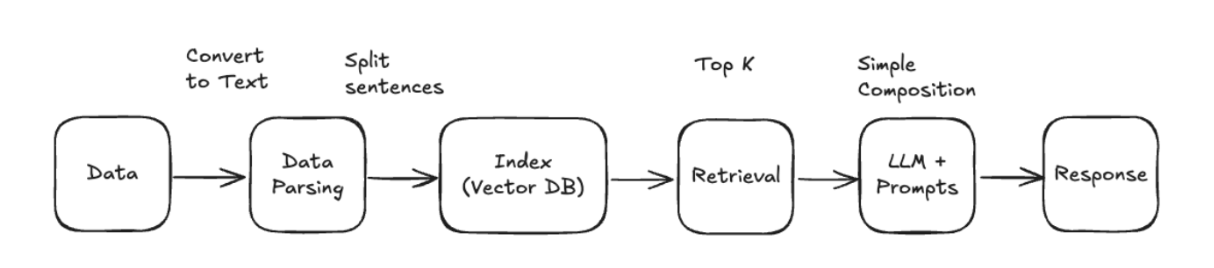

## Limitations of Naive RAG

| Limitation | Problem | Solution |
|------------|---------|----------|
| **Single Modality** | Only searches plain text, misses tables/images | Multi-modal parsing with semantic descriptions |
| **Insufficient Context** | Top-K chunks not enough for summarization | Context enrichment, hierarchical retrieval |
| **Vector Search Limits** | Distance ≠ relevance for complex queries | Hybrid search, reranking |


To overcome these limitations, we need to optimize and upgrade the RAG process 
in two core areas: **Data Quality** and **Query Complexity**.
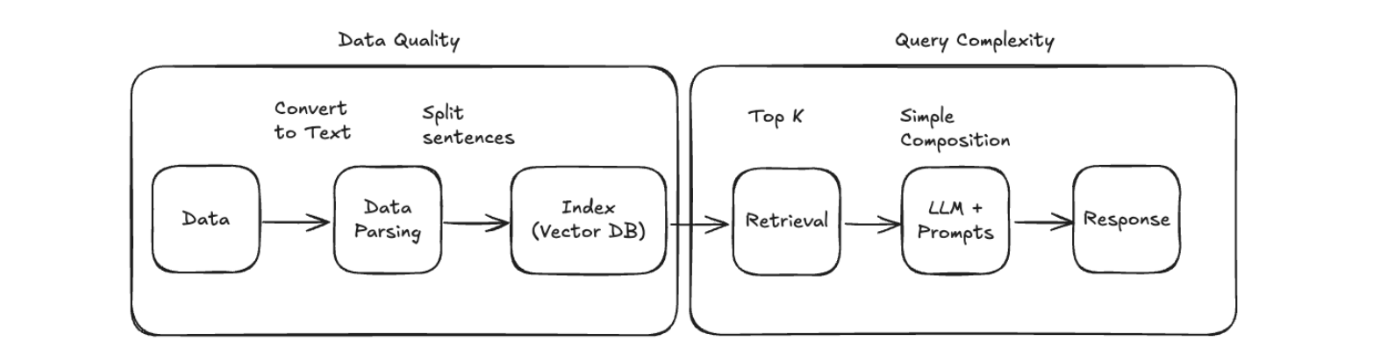

## Ensure Data Quality

The upper limit of a RAG system's performance is determined by the quality of your data. The principle of "Garbage in, garbage out" is acutely true here. Poorly structured or incorrectly formatted data will severely harm RAG performance. 
- RAG is only as good as your data
- Parsing 
  - Wrong data, badly formatted data harms performance
- Chunking
  - Performance of embedding – e.g. if a chunk contains many pieces of irrelevant data, the embedding will not perform
  - Context to retrieve – e.g. if the only first paragraph of a section is embedded and retrieved but the core info needed is in the body which is not retrieved.
- Indexing
  - Embed references to the data source
  - E.g. for tables and charts, generate different kinds of insight summaries and embed those.

Ask yourself: **"As a human, what information would I need to answer this question?"**

If your system can't retrieve that information, you have a data quality problem.

**Goal:** Convert messy files into structured, multimodal document blocks, preserving source-of-truth context.

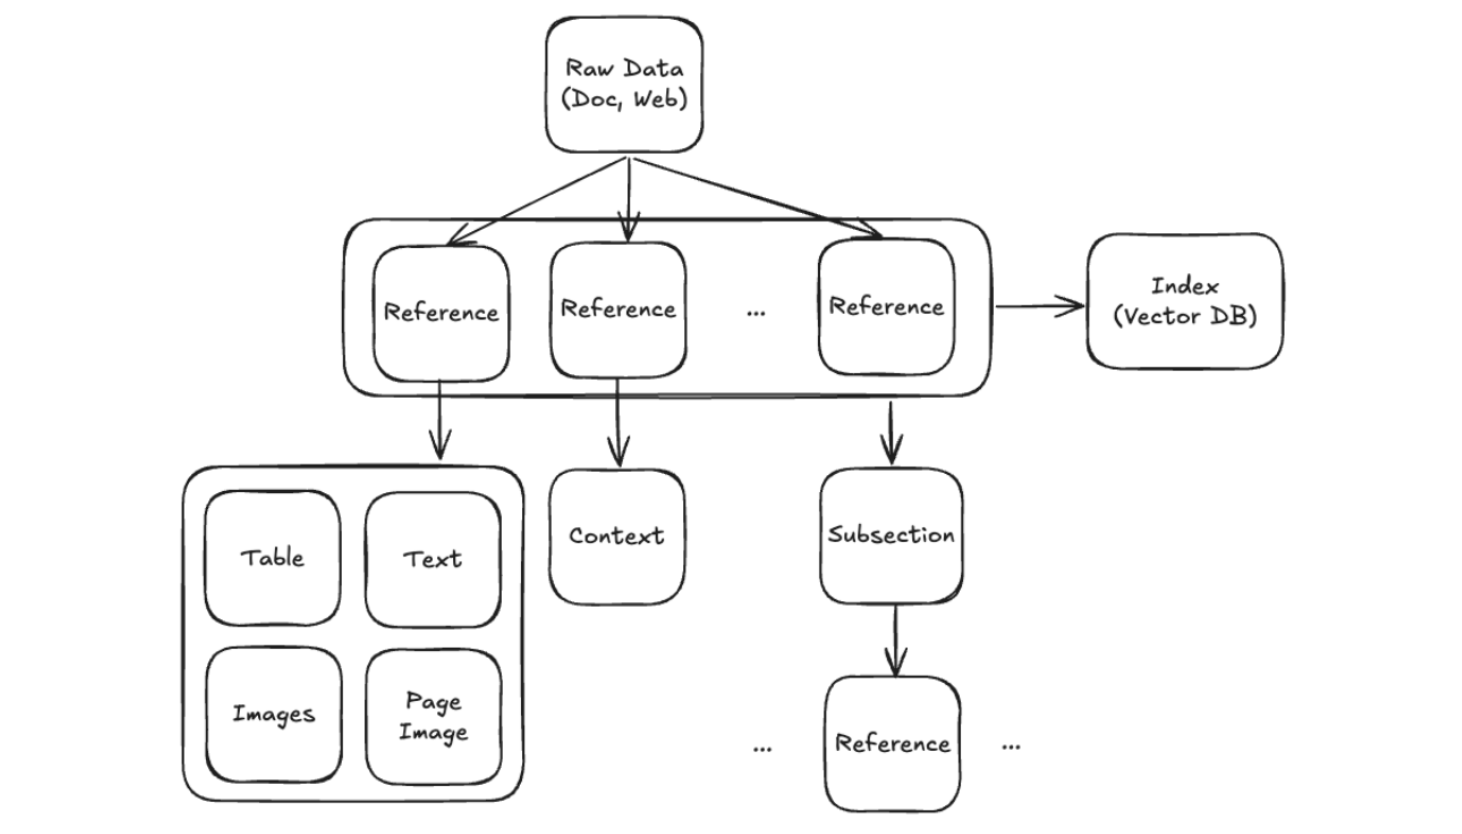

### Advanced Parsing 

- **LLM-Initiated Parsing**: Use multimodal models (e.g., GPT-4 Vision) to:
    - Parse documents visually
    - Identify and classify content blocks (titles, paragraphs, tables, figures, code, captions, etc.)
    - Preserve original multimodal information

- **Multi-Modality Context**
    - Keep the original reference (table image, chart screenshot)
    - Maintain text + image + layout relationships
    - Allow multiple layers of references (e.g., table → caption → chapter → document)

- **Parsing Output Structure**   

    Target representation:   
    Document → Page → Block → Chunk

    Where:
    - Document: entire file
    - Page: physical/logical page
    - Block: semantic unit (table, paragraph, heading, image, etc.)
    - Chunk: text prepared for embeddings




### Intelligent Chunking
Chunking strategy directly affects retrieval accuracy.

Challenges:  
- Embedding quality suffers when chunks include noise (headers, footers).
- Context fragmentation happens when a logical idea (e.g., paragraph + table) is split into separate chunks.

**Solutions:**

1. Structured Chunking   
    Chunk based on document structure:
    - Chapters
    - Sections
    - Paragraphs
    - List items
    - Table + caption as a unit

2. Context Enrichment
    After retrieval:
    - Fetch neighbor chunks (previous + next)
    - Preserve original document order

Good vs Bad Chunking
- Bad: fixed 500-character splits → headings and bullets split apart
- Good: treat an entire section (heading + bullets) as one logical chunk


**Chunking controls how much of an idea lives inside a vector.**    
Better chunking → dramatically better retrieval → better RAG answers.



### Optimized Indexing (Beyond Raw Text)

What we store in the vector database does not have to be the original text.  

Challenge: Raw text from tables/charts is often poorly understood by embedding models.    

**Solutions:**  

- **Embedding References**     

    Instead of embedding the raw block:
    - Embed a reference or summary
    - Keep original multimodal data in metadata

    ```text
    Reference 1 ─┐
    Reference 2 ─┼──► Context ──► Chunk
    Reference 3 ─┘
    ```
    Each reference can contain: Table, Text, Images, Page Image

- **Generate Semantic Summaries**

    For tables & charts:
    - Produce LLM-generated insight summaries
    - Embed those summaries (more semantic)  

    Example - Instead of embedding raw HTML:
    ```text
    Original: <table><tr><th>Q</th><th>Revenue</th>...
    Embed: "Revenue comparison showing 35% YoY growth in Q3 2024"
    ```

- **Hypothetical Queries (HyPE)**

    During indexing:  
    - Use LLMs to generate potential user questions per chunk during indexing: 
        ```text
        Chunk: "The return policy allows 30-day returns for unused items..."
        Generated Qs: 
        - "What is the return policy?"
        - "How many days do I have to return an item?"
        - "Can I return used items?"
        ```
    - Embed both the chunk AND these questions
    - Great for systems with historical FAQ data

---



# 11. The Complete Indexing Pipeline
From parsed document to vector index & naive retrieval

## naive RAG retrieval loop

### Indexing Time (Offline)

```text
0. Raw Document (PDF/HTML/URL)
   │
   ▼
1. Parse into Document → Page → Block
   │  • Use Vision + LLM parsing
   │  • Identify block types
   │  • Generate semantic descriptions
   │
   ▼
2. Chunk Creation
   │  • Structure-aware chunking
   │  • Apply size/overlap rules
   │  • Maintain block references
   │
   ▼
3. Embedding Generation
   │  • Clean text + semantic summary
   │  • Call embedding API
   │  • Get vector per chunk
   │
   ▼
4. Store in Vector Database
   • Vectors + text + metadata
   • doc_id, page, section, block_ids
```

1. Raw document (PDF/HTML/URL) ➡️ parsed into Document ➡️  Page ➡️ Block.
2. Blocks are merged into chunks using structure-aware chunking + size/overlap rules.
3. For each chunk, we generate:
   - Clean text + optional semantic summary,
   - An embedding vector using our chosen embedding model.
4. We store vectors + text + metadata (doc id, page, section, block ids) in a vector database (e.g., ChromaDB or FAISS-backed store)

### Query Time (Online)

```text
0. User Query
   │
   ▼
1. Embed Query
   │  • Same embedding model as indexing
   │
   ▼
2. Top-K Similarity Search
   │  • Apply metadata filters (tenant, doc type)
   │  • Optional: Hybrid search with keywords
   │
   ▼
3. Context Enrichment
   │  • Fetch neighboring chunks
   │  • Deduplicate
   │
   ▼
4. Build RAG Prompt
   │  • System prompt + retrieved context + query
   │
   ▼
5. LLM Generation
   • Generate answer grounded in context
   • Include citations (doc + page)
```

1. User query → embed into a query vector.
2. Run **Top-K similarity search** in the vector DB with metadata filters (e.g., tenant, doc type).
3. Take the Top-K chunks (+ neighbors for context enrichment) and build the RAG prompt.
4. LLM generates an answer that is grounded in these chunks, ideally with citations back to document & page.

> This pipeline is what you should be ready to describe end-to-end in interviews.

## Advanced RAG Pipeline (Full Real-World Version)

### Indexing Time (Offline, Optimized Pipeline)
```text
0. Raw Document (PDF / HTML / URL / DOCX / Webpages)
   │
   ▼
1. Advanced Multimodal Parsing
   │  • Vision+LLM parsing (e.g., GPT-4 Vision)
   │  • Detect tables, charts, figures, lists, code, headers/footers
   │  • Extract structured blocks: Title / Heading / Paragraph / Table / Figure
   │  • Preserve multimodal references (images, structured tables)
   │  • Generate semantic descriptions for each block
   │
   ▼
2. Structure-Aware Chunk Construction
   │  • Merge blocks into logical units (section, paragraph, table+caption)
   │  • Apply token-based size & overlap rules (300–600 tokens)
   │  • Maintain block→chunk lineage via metadata
   │  • Avoid splitting semantic units
   │
   ▼
3. Semantic Indexing (Optimized Embeddings)
   │  • Clean text (remove noise, headers/footers)
   │  • Add semantic summaries for tables/charts
   │     - E.g., "Revenue comparison with 35% YoY growth in Q3 2024"
   │  • Optionally: Hypothetical Query Embeddings (HyPE)
   │     - LLM generates possible user questions and embeds them
   │  • Produce a vector per (chunk or summary or hypothetical query)
   │
   ▼
4. Store in Vector Database
   │  • Store vectors + semantic summaries + clean text + metadata
   │  • Metadata: doc_id, page, section, block_ids, source_url, tenant_id
   │  • Support hybrid search (vector + keyword)
   │
   ▼
5. Optional: Quality Validation
      • Deduplicate chunks
      • Check for missing blocks
      • Ensure semantic coverage
      • Validate summaries using LLM self-check
```
1.	Advanced parsing → structured blocks
2.	Structure-aware chunking → logical chunks
3.	Semantic indexing → summaries + hypothetical queries
4.	Metadata-rich storage → better filtering
5.	Quality checks → reduce hallucination risk

### Query Time (Online, Advanced RAG Retrieval Loop)
```text
0. User Query
   │
   ▼
1. Embed Query (or use query rewriting)
   │  • Embed using same embedding model
   │  • Optionally generate rewritten queries (query expansion)
   │
   ▼
2. Hybrid / Multi-Stage Retrieval
   │  • Vector similarity search (Top-K)
   │  • Keyword/BM25 hybrid search
   │  • Filter by metadata (tenant, doc type, date range)
   │  • Rerank results with cross-encoder or LLM reranker
   │
   ▼
3. Context Enrichment & Reconstruction
   │  • Fetch neighboring chunks
   │  • Retrieve related tables/images referenced in metadata
   │  • Rebuild original document structure where useful
   │  • Deduplicate + prioritize high-confidence chunks
   │
   ▼
4. Build the Final RAG Prompt
   │  • System prompt
   │  • Retrieved context (sorted by relevance)
   │  • Original query
   │  • Optional: citations or metadata
   │  • Optional: chain-of-thought suppression ("don’t reveal reasoning")
   │
   ▼
5. LLM Answer Generation (Grounded & Verified)
      • Produce grounded answers with citations
      • Use reference blocks to cite pages/sections
      • Optional: self-check or verify against context
```

## Naive VS Advanced

 | Stage | Naive RAG  | Advanced RAG | 
  | ---- | ------- | ----- | 
 | Parsing | plain text | multimodal block-level parsing | 
 | Chunking | fixed-size | structure-aware, semantic | 
 | Embeddings | raw text | summaries + references + HyPE | 
 | Indexing | plain vectors | rich metadata + hybrid search | 
 | Retrieval | top-K | hybrid + reranking + enrichment | 
 | Prompting | plain context | structured + citations + verification | 


# Summary

| Component | Key Concept | Why It Matters |
|-----------|-------------|----------------|
| **Parsing** | Vision + LLM hybrid | Preserves structure and semantics |
| **Document Hierarchy** | Doc → Page → Block → Chunk | Enables precise retrieval and citations |
| **Semantic Content** | LLM-generated descriptions | Tables/charts become searchable |
| **Embeddings** | Text → N-dimensional vectors | Enables semantic similarity search |
| **Chunking** | Structure-aware with overlap | Complete context in each chunk |
| **Vector DB** | Fast ANN + metadata filtering | Scalable retrieval with access control |
| **Hybrid Search** | Semantic + keyword | Best of both worlds |

**The Bottom Line:** RAG quality is capped by data quality. Investing in proper parsing, intelligent chunking, and semantic enhancement of structured content pays dividends throughout the entire system.
